---
<p style="text-align: center;font-size: 2em;font-weight: bold;">
Projet numérique de Probabilités 2025/26
</p>

---


# Introduction

On va s'intéresser à la simulation de champs aléatoires gaussiens. On peut définir un champ aléatoire Gaussien comme une collection de variables aléatoires indexées par un ensemble telles que toute combinaison linéaire finie de ces variables aléatoires suit une loi normale. Pour simplifier, nous nous intéresserons à des champs aléatoires gaussiens définis sur une grille régulière de points dans un domaine  $\mathbb{R}^2$. 

Un champ aléatoire Gaussien est entièrement caractérisé par son espérance et sa fonction de covariance. L'espérance est une fonction qui attribue à chaque point du domaine la valeur moyenne de la variable aléatoire associée à ce point. La fonction de covariance est une fonction qui décrit comment les variables aléatoires associées à deux points différents du domaine sont corrélées entre elles. 

Un exemple classique de fonction de covariance est la fonction exponentielle quadratique (ou gaussienne) définie par :
$$C(x, y) = \sigma^2 \exp\left(-\frac{\|x - y\|^2}{a}\right)$$
où  $\sigma^2$ est la variance,  $a$ est le facteur d'échelle, et $\|x - y\|$ est la distance euclidienne entre les points  $x$ et $y$.
Une telle fonction de covariance implique que les points proches dans le domaine ont des valeurs de champ aléatoire fortement corrélées, tandis que les points éloignés ont des valeurs faiblement corrélées. Elle est souvent utilisée pour modéliser des phénomènes naturels où la corrélation diminue avec la distance. 

Dans ce projet, nous allons implémenter une méthode pour simuler des champs aléatoires gaussiens sur une grille régulière de points dans un domaine  $\mathbb{R}^2$. Nous utiliserons dans un premier temps la méthode de la décomposition de Cholesky pour générer des échantillons de champs aléatoires gaussiens à partir de leur fonction de covariance. Dans un second temps, nous explorerons une méthode plus efficace basée sur la représentation spectrale de la fonction de covariance. Enfin, nous verrons comment conditionner ces simulations sur des observations ponctuelles.

# Simulation par la méthode de Cholesky

Quitte à réarranger les points de la grille, on peut supposer que l'on a une liste finie de points  $x_1, x_2, \ldots, x_n$ dans  $\mathbb{R}^2$ où l'on souhaite simuler le champ aléatoire Gaussien. La fonction de covariance  $C$ permet de construire la matrice de covariance  $K$ définie par :

$$K_{ij} = C(x_i, x_j)$$

On va implementer la méthode de Cholesky pour générer des réalisations de champs aléatoires gaussiens à partir de cette matrice de covariance.

1. Ecrire une fonction "covariance_gaussienne" qui prend en entrée une matrice de distances, ainsi que les paramètres  $\sigma^2$ et  $a$, et qui retourne la valeur de la fonction de covariance gaussienne entre ces deux points.

In [1]:
import numpy as np
from scipy.spatial import distance_matrix
import scipy.spatial as scp
import matplotlib.pyplot as plt

def covariance_gaussienne(matrice_distance, variance, a):
    n = len(matrice_distance[0])
    M= [[None for _ in range(n)] for k in range(n)]
    for i in range(n):
        for j in range(n):
            M[i][j] = variance * np.exp(-(matrice_distance[i][j])**2/a)
    return M

np.random.seed(12345)

2. Discrétiser le domaine  $[0, 1] \times [0, 1]$ en une grille régulière de  $n \times n$ points (par exemple,  $n = 50$). Construire la matrice de distances entre tous les points de la grille.

In [2]:
def discretisation(n):
    M= np.empty((n, n, 2)) # on initialise une grille
    valeurs = np.linspace(0, 1, n, endpoint=True) # on divise le segment [0,1] en n points
    for i in range(n):
        for j in range(n):
            M[i, j] = [valeurs[i], valeurs[j]] # on remplie la grille avec les coordonnées des points
    # on convertit la matrice de coordonées en une liste de n^2 tuples pour correspondre au format de distance_matrix
    LISTE_POINTS = M.reshape(n**2, 2)
    # on obtient une matrice carrée n**2 où DIST[i][j]correspond à la distance le point i et le point j de la liste
    # Par rapport  à la correspondance à M : M[i][j] == LISTE_POINTS[i*n+j]
    return scp.distance_matrix(LISTE_POINTS, LISTE_POINTS)


3. Utiliser la fonction "covariance_gaussienne" pour construire la matrice de covariance $K$ en évaluant la fonction de covariance pour chaque paire de points dans la grille puis calculer la décomposition de Cholesky de $K$ (voir *np.linalg.cholesky*).

On choisira ici  $\sigma^2 = 1$ et  $a = 0.05$.

NB : Pour assurer la stabilité numérique, on peut ajouter un petit terme de régularisation à la diagonale de la matrice de covariance avant de calculer la décomposition de Cholesky (par exemple,  $10^{-10} I$ où  $I$ est la matrice identité).

In [5]:
sigma2 = 1.0
a = 0.05

def matrice_cov(n,a, sigma2):
    matrice_distance = discretisation(n) # fabrication de la matrice distance
    return covariance_gaussienne(matrice_distance, sigma2, a) # calcul de la covariance

def decompo_Cholesky(matrice):
    matrice = matrice +(np.identity(len(matrice))*10**(-10)) # on applique le conseil pour la stabilité numérique
    return np.linalg.cholesky(matrice) # calcul de la décomposition de Cholesky

4. Générer et représenter une réalisation du champ aléatoire Gaussien centré et de covariance $K$.

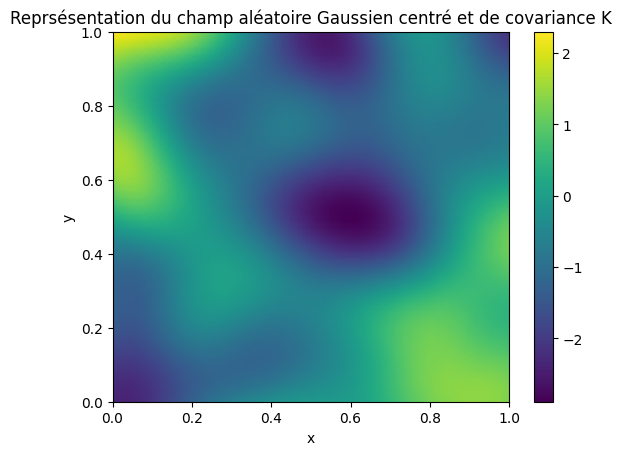

In [24]:
import matplotlib.pyplot as plt

n = 50
sigma2 = 1.0
a = 0.05

# On applique la méthode de Cholesky (cf. chapitre V) 
matrice = matrice_cov(n, a, sigma2)
L = decompo_Cholesky(matrice)
Y = np.random.normal(0,1, size=len(matrice))
Z = L @ Y
grille = Z.reshape(n,n)
# Maintenant on gère l'affichage :
A = np.linspace(0, 1, n, endpoint=True)
B = np.linspace(0, 1, n, endpoint=True)
plt.pcolormesh(A, B, grille, shading="gouraud")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reprsésentation du champ aléatoire Gaussien centré et de covariance K")
plt.show()


5. Essayer d'augmenter le nombre de pas de discrétisation. Que remarquez-vous ? Expliquer pourquoi.

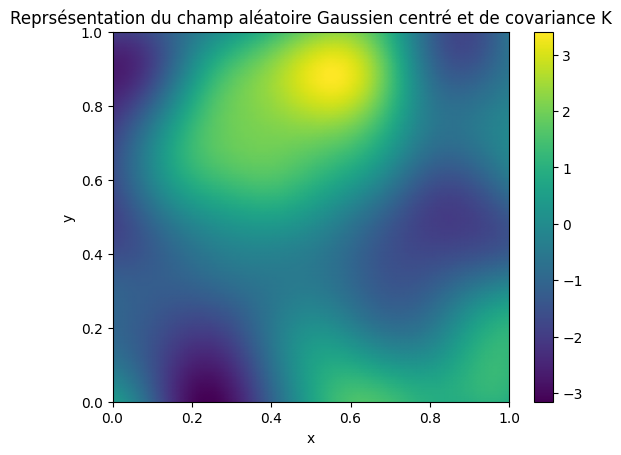

In [23]:
# On essaye pour différentes valeurs de n :
n = 100
sigma2 = 1.0
a = 0.05

# On applique la méthode de Cholesky (cf. chapitre V)
matrice = matrice_cov(n, a, sigma2)
L = decompo_Cholesky(matrice)
Y = np.random.normal(0,1, size=len(matrice))
Z = L @ Y
grille = Z.reshape(n,n)
A = np.linspace(0, 1, n, endpoint=True)
B = np.linspace(0, 1, n, endpoint=True)
# Maintenant on gère l'affichage :
plt.pcolormesh(A, B, grille, shading="gouraud")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reprsésentation du champ aléatoire Gaussien centré et de covariance K")
plt.show()

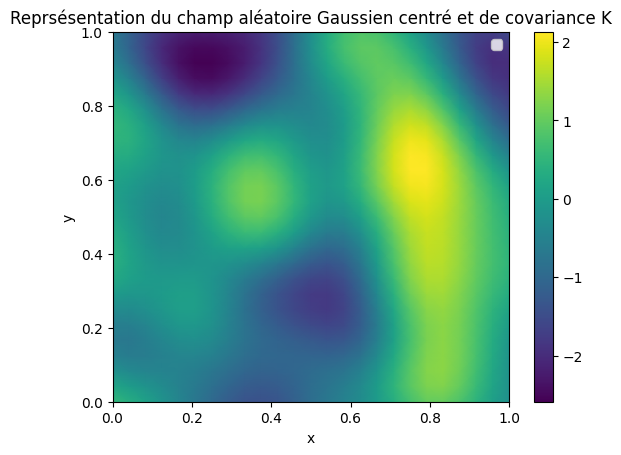

In [ ]:
# n = 25
n = 25
sigma2 = 1.0
a = 0.05

matrice = matrice_cov(n, a, sigma2)
L = decompo_Cholesky(matrice)
Y = np.random.normal(0,1, size=len(matrice))
Z = L @ Y
grille = Z.reshape(n,n)
A = np.linspace(0, 1, n, endpoint=True)
B = np.linspace(0, 1, n, endpoint=True)
plt.pcolormesh(A, B, grille,shading="gouraud")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reprsésentation du champ aléatoire Gaussien centré et de covariance K")
plt.show()

Pour n = 50 le programme met envrion 8 secondes pour afficher le graphique, pour n = 25 seulement 3 secondes sont nécessaires. En revanche pour n = 100 il faut plus de 2 minutes pour avoir un résultat !
En effet lors des différents programmes, notamment celui discrétisation on utilise une matrice $ n^2 * n^2 $. Ainsi en multipliant n par 2 on multiplie le nombre de points par 4. Comme il y a beaucoup d'étapes de calculs (calcul de la distance pour tous les points, calul de C(i,j) pour la matrice $n^2$, factorisation de Cholesky, représentation graphique, ...), ce facteur 4 ralentit d'autant plus l'efficacité de notre programme.
Sa complexité est très mauvaise.

# Simulation par la méthode spectrale 

Vu les limitations de la méthode de Cholesky pour des grilles fines, nous allons explorer une méthode alternative basée sur la représentation spectrale de la fonction de covariance. 

1. Soit $C(h) = \exp\left(-\frac{\|h\|^2}{a}\right)$, où $h \in \mathbb{R}^2$. Montrer que :
$$ C(h) = \int_{\mathbb{R}^2} \cos(\langle w, h \rangle) \frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right) dw $$

NB: on pourra s'inspirer du calcul de la fonction caractéristique d’un vecteur gaussien en annexe du chapitre IV du cours.

On note la fonction $f$ telle que :$\newline\
f : \mathbb{R^2}\longrightarrow\mathbb{R^2}\newline
\omega\longrightarrow\ isin(<\omega|h>)\frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right)$

On a $f(\omega)=-f(-\omega)$ d'où $f$ est impaire et donc son intégrale est nulle sur $\mathbb{R^2}$. D'où : 

$I = \int_{\mathbb{R}^2}\cos(<\omega|h>)\frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right)dw = \int_{\mathbb{R}^2}\exp\left(i<w|h>\right)\frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right)dw = \int_{\mathbb{R}^2}\exp\left(i(x_1h_1+x_2h_2)\right)\frac{a}{4\pi}\exp\left(-\frac{a(x_1^2+x_2^2)}{4}\right)dx_1dx_2$

En utilisant Fubini (car f est intégrable), on obtient : $ I = \frac{a}{4\pi}(\int_{\mathbb{R}}\exp\left(i(xh_1)-a\frac{x^2}{4}\right)dx)(\int_{\mathbb{R}}\exp\left(i(yh_1)-a\frac{y^2}{4}\right)dy) = \frac{a}{4\pi}I_xI_y $

On a : $I_x = \int_{\mathbb{R}}\exp\left(-\frac{a}{4}(x-\frac{2ih_1}{a})^2\right)exp\left(\frac{a}{4}(\frac{2ih_1}{a})^2\right)dx = exp\left(-\frac{h_1^2}{a}\right)\int_{\mathbb{R}}\exp\left(-\frac{a}{4}(x-\frac{2ih_1}{a})^2\right)dx$

On pose $u = \sqrt{\frac{a}{4}}(x-\frac{2ih_1}{a})$ alors $ \frac{2}{\sqrt{a}}du = dx$ et par changement de variable : 

$I_x = exp\left(-\frac{h_1^2}{a}\right)\frac{2}{\sqrt{a}}\int_{\mathbb{R}}\exp\left((-u)^2\right)du = exp\left(-\frac{h_1^2}{a}\right)2\sqrt{\frac{\pi}{a}}$

De même, on obtient : $I_y = exp\left(-\frac{h_2^2}{a}\right)2\sqrt{\frac{\pi}{a}}$

D'où finalement : $ I = \frac{a}{4\pi}(exp\left(-\frac{h_1^2}{a}\right)2\sqrt{\frac{\pi}{a}})(exp\left(-\frac{h_2^2}{a}\right)2\sqrt{\frac{\pi}{a}}) = \exp\left(-\frac{h_1^2+h_2^2}{a}\right) = \exp\left(-\frac{\|h\|^2}{a}\right) = C(h) $


2. Soient $W$ et $\Phi$ deux variables aléatoires indépendantes, de lois respectives $\mathcal{N}(0, \frac{2}{a} I_2)$, avec $I_2$ la matrice identité de dimension 2, et $\mathcal{U}[0, 2\pi[$. Montrer que la variable aléatoire définie en tout point $x \in \mathbb{R}^2$ par :
$$ Z(x) = \sqrt{2} \cos(\langle W, x \rangle + \Phi) $$
est d'espérance nulle et de fonction de covariance $C$.



On note $ Y = (W, \phi)$. On a $f_Y = f_Wf_\phi$ par indépendance. On a pour $x\in\mathbb{R}^2, y\in\mathbb{R}^2$ :

$E(Z(x)) = \int_{\mathbb{R}\times[0, 2\pi[}\sqrt{2} \cos(\langle W, x \rangle + \Phi)f_Y(y)dy = \frac{\sqrt{2}}{2\pi}\int_{\mathbb{R}}(\int_{[0, 2\pi[}\cos(\langle W, x \rangle + \Phi)d\phi)f_W(w)dw = 0$ car l'intégrale du cosinus sur $[0, 2\pi[$ est nulle.

Passons maintenant au calcul de la covariance :

$Cov(Z(x),Z(z)) = E(Z(x)Z(z)) = 2\int_{\mathbb{R}\times[0, 2\pi[}\cos(\langle W, x \rangle + \Phi)\cos(\langle W, z \rangle + \Phi)f_Y(y)dy$ avec $y = (w,\phi)$

$Cov(Z(x),Z(z)) = E(\cos(\langle W, x-z \rangle) + \cos(\langle W, x+z \rangle + 2\Phi))$

$Cov(Z(x),Z(z)) = E(\cos(\langle W, x-z \rangle))$ par linéarité de l'espérance, et car si on pose $\tilde{\phi}\rightarrow2\phi$ lorsque $\phi$ fait un tour du cercle trigonométrique $\tilde{\phi}$ en fait deux et donc annule le cosinus. 

$Cov(Z(x),Z(z)) = \int_{\mathbb{R}^2}\cos(\langle W, x-z \rangle)f_W(w)dw$ avec $f_W(w) = \frac{1}{2\pi\sqrt{(\frac{2}{a})^2}}\exp\left(-\frac{1}{2}\frac{2}{a}\|w\|^2\right) = \frac{a}{4\pi}\exp\left(-\frac{a\|w\|^2}{4}\right)$

D'où : $Cov(Z(x),Z(z)) = C(x-z)$ d'après la question précédente.




3. Soient les suites de variables aléatoires indépendantes $(W_n)_{n \in \mathbb{N}}$ et $(\Phi_n)_{n \in \mathbb{N}}$ telles que $W_n \sim \mathcal{N}(0, \frac{2}{a} I_2)$ et $\Phi_n \sim \mathcal{U}([0, 2\pi])$. Montrer que pour tout ensemble fini de points  $x_1, \ldots, x_n$ dans  $\mathbb{R}^2$ , le vecteur aléatoire $Y = (Y(x_1), \ldots, Y(x_n))$ où :
$$ Y(x_i) = \sqrt{\frac{2}{N}} \sum_{k=1}^{N} \cos(\langle W_k, x_i \rangle + \Phi_k) $$
tend vers un vecteur aléatoire de loi normale multivariée d'espérance nulle et de matrice de covariance $K$ définie par  $K_{ij} = C(x_i - x_j)$.

On note $\forall k \in \mathbb{N}, Z_k(x) = \sqrt{2}\cos(\langle W_k, x \rangle + \Phi_k)$

On pose alors $\forall k \in \mathbb{N}, X_k = (Z_k(x_1), ...,Z_k(x_n))$ qui est un vecteur aléatoire d'espérance $(0, ..., 0)$ et de matrice de covariance $K = (K_{i,j}) = (C(x_i-x_j))$.

Soit $N\in \mathbb{N}$. On pose également : $Y_N(x) = (Y_N(x_1), ..., Y_N(x_n))$.

Or : $Y_N = \frac{1}{\sqrt{N}}\sum_{k=1}^{N}X_k$ , et les $(X_k)$ sont indépendants et de même loi car $(W_n)_{n \in \mathbb{N}}$ et $(\Phi_n)_{n \in \mathbb{N}}$ sont mutuellement indépendantes. D'où d'après le théorême central limite multidimensionnel, $Y_N$ converge en loi lorsque $N$ tend vers $+\infty$ vers $\mathcal{N}(0, K)$.






4. Implémenter une fonction basée sur cette méthode pour simuler un champ aléatoire gaussien sur une grille régulière de points dans le domaine  $[0, 1] \times [0, 1]$. Cette fonction prendra en entrée les coordonnées des points de la grille, $a$ et  $N$ et retournera une réalisation du champ aléatoire gaussien simulé.

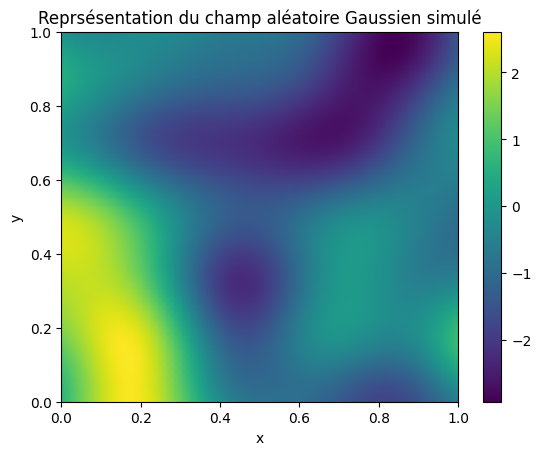

In [49]:
import numpy as np

def C(h, a):
    return np.exp(-(np.linalg.norm(h))**2/a)

def methode_spectrale(liste_coordonees, a, N):
    x=len(liste_coordonees)
    W=[np.random.standard_normal(2)*np.sqrt(2/a) for _ in range(N)]
    PHI=[np.random.uniform(0, 2*np.pi) for _ in range(N)]
    Y=[] 
    for i in range(x):
        # on calcule la valeur de Y(x_i)
        y=0
        for k in range(N):
            y+=np.sqrt(2/N)*np.cos(np.dot(W[k], liste_coordonees[i])+ PHI[k])
        Y.append(y)
    return Y

a=0.05
N=100
n=50
X=np.linspace(0, 1, n, endpoint=True)
Y=np.linspace(0, 1, n, endpoint=True)
liste_coordonees=np.array([[X[i], Y[j]] for i in range(n) for j in range(n)])
vecteur_gaussien=methode_spectrale(liste_coordonees, a, N)
Z = np.array(vecteur_gaussien).reshape(n, n)
plt.pcolormesh(X, Y, Z,shading="gouraud")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reprsésentation du champ aléatoire Gaussien simulé")
plt.show()

5. Tester cette fonction pour différentes valeurs du nombre de points de discrétisation et de $N$. Proposer un diagnostic permettant de calibrer $N$ afin que les résultats soient conformes aux attentes. Comparer les résultats obtenus avec ceux de la méthode de Cholesky. Quels sont les avantages et les inconvénients de chaque méthode ?

In [61]:
import time
X=np.linspace(0, 1, n, endpoint=True)
Y=np.linspace(0, 1, n, endpoint=True)
liste_coordonees=np.array([[X[i], Y[j]] for i in range(n) for j in range(n)])
A= np.linspace(0,5000, 500)
B = []
for N in A:
    debut = time.time() 
    methode_spectrale(liste_coordonees, a, int(N))
    fin = time.time()
    B.append(fin - debut)
plt.plot(A, B)
plt.show()

KeyboardInterrupt: 

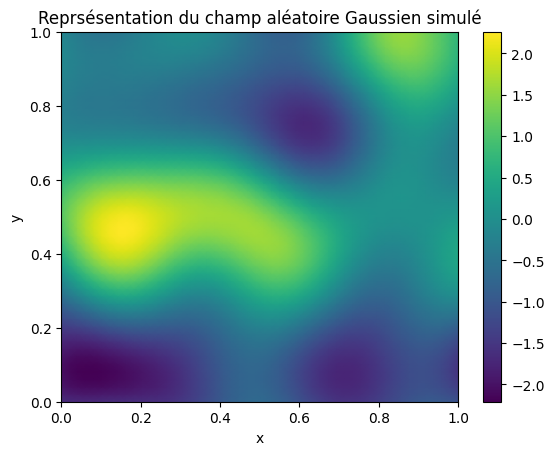

In [50]:
sigma2 = 1.0
a = 0.05
# Tout d'abord on faut varier N :
N=200
n=50
X=np.linspace(0, 1, n, endpoint=True)
Y=np.linspace(0, 1, n, endpoint=True)
liste_coordonees=np.array([[X[i], Y[j]] for i in range(n) for j in range(n)])
vecteur_gaussien=methode_spectrale(liste_coordonees, a, N)
Z = np.array(vecteur_gaussien).reshape(n, n)
plt.pcolormesh(X, Y, Z,shading="gouraud")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reprsésentation du champ aléatoire Gaussien simulé")
plt.show()

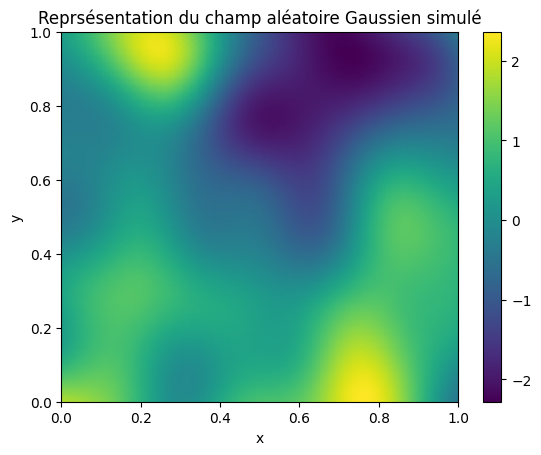

In [51]:
sigma2 = 1.0
a = 0.05
N=300
n=50
X=np.linspace(0, 1, n, endpoint=True)
Y=np.linspace(0, 1, n, endpoint=True)
liste_coordonees=np.array([[X[i], Y[j]] for i in range(n) for j in range(n)])
vecteur_gaussien=methode_spectrale(liste_coordonees, a, N)
Z = np.array(vecteur_gaussien).reshape(n, n)
plt.pcolormesh(X, Y, Z,shading="gouraud")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reprsésentation du champ aléatoire Gaussien simulé")
plt.show()

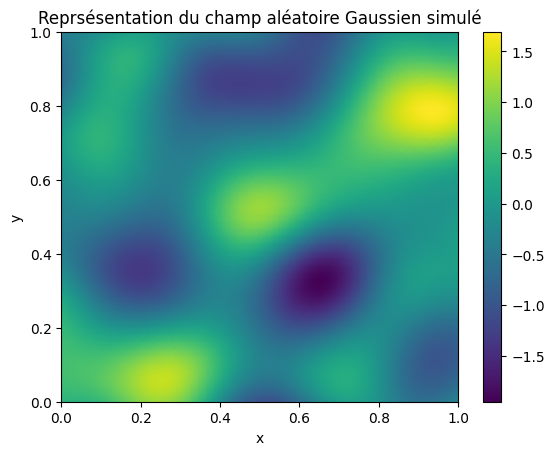

In [58]:
sigma2 = 1.0
a = 0.05
N=10000
n=50
X=np.linspace(0, 1, n, endpoint=True)
Y=np.linspace(0, 1, n, endpoint=True)
liste_coordonees=np.array([[X[i], Y[j]] for i in range(n) for j in range(n)])
vecteur_gaussien=methode_spectrale(liste_coordonees, a, N)
Z = np.array(vecteur_gaussien).reshape(n, n)
plt.pcolormesh(X, Y, Z,shading="gouraud")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reprsésentation du champ aléatoire Gaussien simulé")
plt.show()

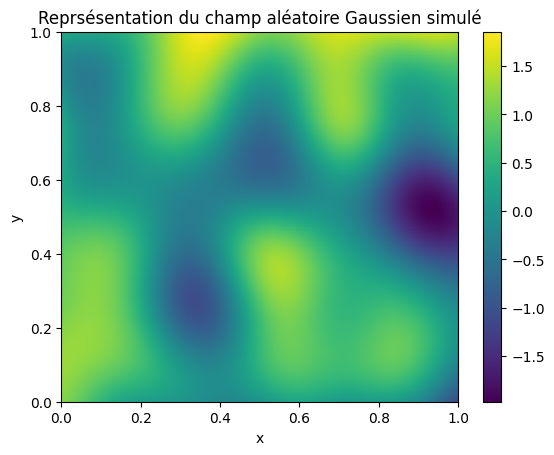

In [54]:
sigma2 = 1.0
a = 0.05
N=100
n=100
X=np.linspace(0, 1, n, endpoint=True)
Y=np.linspace(0, 1, n, endpoint=True)
liste_coordonees=np.array([[X[i], Y[j]] for i in range(n) for j in range(n)])
vecteur_gaussien=methode_spectrale(liste_coordonees, a, N)
Z = np.array(vecteur_gaussien).reshape(n, n)
plt.pcolormesh(X, Y, Z,shading="gouraud")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reprsésentation du champ aléatoire Gaussien simulé")
plt.show()

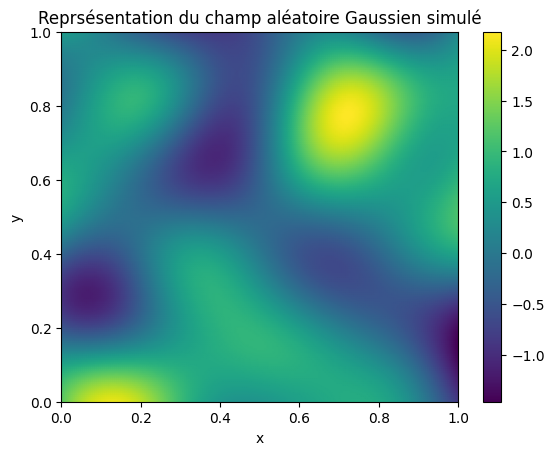

In [55]:
sigma2 = 1.0
a = 0.05
N=100
n=200
X=np.linspace(0, 1, n, endpoint=True)
Y=np.linspace(0, 1, n, endpoint=True)
liste_coordonees=np.array([[X[i], Y[j]] for i in range(n) for j in range(n)])
vecteur_gaussien=methode_spectrale(liste_coordonees, a, N)
Z = np.array(vecteur_gaussien).reshape(n, n)
plt.pcolormesh(X, Y, Z,shading="gouraud")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reprsésentation du champ aléatoire Gaussien simulé")
plt.show()

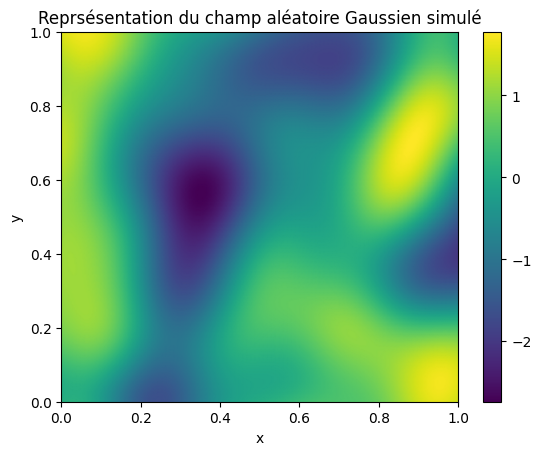

In [56]:
sigma2 = 1.0
a = 0.05
N=100
n=300
X=np.linspace(0, 1, n, endpoint=True)
Y=np.linspace(0, 1, n, endpoint=True)
liste_coordonees=np.array([[X[i], Y[j]] for i in range(n) for j in range(n)])
vecteur_gaussien=methode_spectrale(liste_coordonees, a, N)
Z = np.array(vecteur_gaussien).reshape(n, n)
plt.pcolormesh(X, Y, Z,shading="gouraud")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reprsésentation du champ aléatoire Gaussien simulé")
plt.show()

# Simulation conditionnelle 

On suppose désormais que l'on dispose de valeurs observées du champ aléatoire Gaussien en certains points du domaine. On souhaite simuler des réalisations conditionnelles du champ aléatoire Gaussien en tenant compte de ces observations. On travaillera désormais avec une grille de taille $100 \times 100$.
Soit $X$ un vecteur aléatoire Gaussien partitionné en deux sous-vecteurs $X_1$ et $X_2$, où $X_1$ représente les points observés et $X_2$ les points non observés. 

1. Rappeler l'expression de la distribution jointe de $X = (X_1, X_2)$ puis de la distribution conditionnelle de $X_2$ sachant $X_1$. Montrer que la différence entre l'espérance conditionnelle et le vecteur des points non observés est un vecteur Gaussien d'espérance nulle indépendant du vecteur des points non observés.

On va donc chercher à simuler directement cette différence pour obtenir des réalisations conditionnelles du champ aléatoire Gaussien.

2. Générer 50 points uniformément répartis dans le domaine  $[0, 1] \times [0, 1]$ et simuler des observations du champ aléatoire Gaussien en ces points.


In [ ]:
# On génère 50 points aléatoires
n=50
N=1000
X=np.random.uniform(0, 1, n)
Y=np.random.uniform(0, 1, n)
liste_coordonees=np.array([[X[i], Y[j]] for i in range(n) for j in range(n)])
vecteur_gaussien=methode_spectrale(liste_coordonees, a, N)
Z = np.array(vecteur_gaussien).reshape(n, n)
plt.pcolormesh(X, Y, Z,shading="gouraud")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Reprsésentation du champ aléatoire Gaussien simulé")
plt.show()


3. Calculer l'espérance conditionnelle aux points de la grille et la représenter.

NB : Pour assurer la stabilité numérique, on doit ajouter un terme de régularisation plus important à la diagonale de la matrice de covariance avant de calculer son inverse ($10^{-2} I$ conviendra ici).

In [ ]:
sigma2 = 1.0
a = 0.05

def esperance_conditionnelle():

4. Pour générer de manière indépendante la différence entre l'espérance conditionnelle et le vecteur des points non observés, on génère une seconde réalisation du champ aléatoire aux points de la grille **et** aux coordonnées des points observés par la méthode spectrale. On calcule ensuite la différence entre cette réalisation et l'espérance conditionnelle sachant les valeurs simulées aux coordonnées des points observés. Enfin, on additionne cette différence à l'espérance conditionnelle sachant les observations pour obtenir une réalisation conditionnelle du champ aléatoire Gaussien sur la grille. Implémenter cette approche et représenter une réalisation conditionnelle du champ aléatoire Gaussien sur la grille.

5. Générer 500 simulations conditionnelles et comparer la moyenne empirique de ces simulations avec l'espérance conditionnelle calculée précédemment. Que constate-t-on ? Expliquer pourquoi.

# Simulation non-stationnaire

On souhaite désormais simuler un champ aléatoire Gaussien non-stationnaire, c'est-à-dire dont la fonction de covariance dépend de la position dans le domaine. Ces modèles plus complexes offrent une plus grande flexibilité pour modéliser des phénomènes naturels. En particulier, on va chercher à faire varier la valeur du paramètre d'échelle $a$ en fonction de la position. On considère une fonction de covariance de la forme :
$$C(x, y) = 2\frac{\sqrt{a(x) a(y)}}{a(x)+a(y)} \exp\left(-\frac{2\|x - y\|^2}{a(x)+a(y)}\right),$$
où $a : [0,1]^2 \to \mathbb{R}_+^*$ est une fonction définissant le paramètre d'échelle en chaque point du domaine.

Pour générer des réalisations de ce champ aléatoire non-stationnaire, on peut adapter la méthode spectrale en utilisant une approche locale. Précisément, on va considérer la modification suivante de la méthode spectrale :

$$Z(x) = \sqrt{\frac{2f_x(W)}{g(W)}}\cos(\langle W, x \rangle + \Phi)$$

où $W$ et $\Phi$ sont deux variables aléatoires indépendantes, de lois respectives $\mathcal{N}(0, \frac{2}{a} I_2)$ et $\mathcal{U}[0, 2\pi[$, et où $f_x$ est la densité de la loi $\mathcal{N}(0, \frac{2}{a(x)} I_2)$ et $g$ est la densité de la loi $\mathcal{N}(0, \frac{2}{a} I_2)$ pour $a = \inf_{x \in [0,1]^2} a(x)>0$, avec $a>0$.

1. Justifier que cette modification permet de simuler un champ aléatoire Gaussien non-stationnaire avec la fonction de covariance donnée précédemment. Quelle technique de simulation vue en cours est-elle utilisée ici ?

2. Implémenter cette méthode pour simuler un champ aléatoire Gaussien non-stationnaire sur une grille régulière de points dans le domaine  $[0, 1] \times [0, 1]$. On choisira, par exemple, une fonction $a(x)$ variant linéairement selon l'axe des ordonnées entre deux valeurs $a_{min}=0.01$ et $a_{max}=0.1$ sur le domaine. Commenter les résultats obtenus.